# Hazard Ratio Degradation: From As-Treated to Intention-to-Treat

## What this notebook shows

The Alzheimer's simulation dials in a **treatment relative risk (RR) of 0.528** for
the BBBM-to-MCI transition. But when we measure the treatment effect using a Cox
proportional hazards model, the observed **hazard ratio (HR)** depends on how much
"diluted" person-time we include in the analysis.

This notebook demonstrates the HR degradation across **five analysis strategies**,
from the most restrictive (isolating only the period of full drug effect) to the
broadest (intention-to-treat):

| # | Analysis | Person-time included (treated arm) | Expected HR |
|---|----------|-------------------------------------|-------------|
| 1 | **As-treated: full effect** | `treatment_effect` only (RR=0.528) | ~0.53 |
| 2 | **As-treated: effect + waning** | Through `waning_effect` (RR: 0.528 -> 1.0) | ~0.55 |
| 3 | **Per-protocol: full course** | Through `no_effect_after_treatment` (RR=1.0) | ~0.57 |
| 4 | **From treatment offer** | From `waiting_for_treatment` entry (adds RR=1.0 wait) | ~0.59 |
| 5 | **Intention to treat (CRN)** | From BBBM entry, vs CRN-matched untreated | ~0.61 |

## Background for new readers

### Disease model
- Simulants progress through: **BBBM** (preclinical) -> **MCI** -> **Dementia**
- Only the BBBM-to-MCI transition is affected by treatment
- BBBM and MCI have zero excess mortality; only Dementia increases death risk

### Treatment pipeline
```
susceptible -> waiting_for_treatment -> treatment_effect -> waning_effect -> no_effect_after_treatment
          \-> no_effect_never_treated  (refused, permanent)
```
- `waiting_for_treatment`: ~1 step (6 months), RR = 1.0 (no protection yet)
- `treatment_effect`: ~6 years, RR = 0.528 (full protection)
- `waning_effect`: ~11 years, RR ramps linearly from 0.528 back to 1.0
- `no_effect_after_treatment`: RR = 1.0 (drug fully worn off)

### Common Random Numbers (CRN)
Vivarium uses CRN so that the same simulant IDs exist across scenarios with
identical random draws. This lets us compare the *same* simulant's outcome under
treatment vs no treatment -- the gold standard counterfactual.

In [1]:
# === Standard library ===
import math
import warnings

# === Data / plotting ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Survival analysis (pip install lifelines) ===
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# === Simulation ===
from tqdm.auto import tqdm
from vivarium import InteractiveContext

# Suppress noisy vivarium INFO logs during simulation.
# Vivarium uses loguru (not Python's standard logging module), so
# logging.getLogger().setLevel() has no effect on it.
from loguru import logger
logger.disable("vivarium")

# --- Constants ---
SPEC_PATH = '../src/vivarium_csu_alzheimers/model_specifications/model_spec.yaml'
POPULATION_SIZE = 10_000       # 10k gives good precision; 20k for publication-quality
STEP_SIZE_DAYS = 182           # ~6 months per step
STEP_SIZE_YEARS = STEP_SIZE_DAYS / 365.25

# Disease state column and values
DISEASE_COL = 'alzheimers_disease_and_other_dementias'
BBBM_STATE = 'alzheimers_blood_based_biomarker_state'
MCI_STATE = 'alzheimers_mild_cognitive_impairment_state'
DEMENTIA_STATE = 'alzheimers_disease_state'

TREATMENT_COL = 'treatment'
TARGET_YEAR = 2070             # Run far enough for treatment effects to fully play out

# The treatment relative risk dialed into the simulation (draw_0)
TREATMENT_RR = 0.528

## Step 1: Run simulations and collect per-simulant event data

We run two scenarios:
1. **`bbbm_testing`** (testing only, no treatment) -- serves as the untreated control for ITT
2. **`bbbm_testing_and_treatment`** (testing + treatment) -- the treatment arm

For each simulant we record:
- When they entered/exited BBBM and where they went (MCI or dead)
- When they died (if applicable)
- Treatment state transition timestamps (pipeline entry, treatment_effect start/end,
  waning_effect end, refusal time)

In [2]:
def run_scenario(scenario, target_year=TARGET_YEAR):
    """
    Run a single scenario and track per-simulant events.
    
    Returns a dict with:
      bbbm_enter_time:          {sid: Timestamp}  -- first BBBM entry
      bbbm_exit_time:           {sid: Timestamp}  -- first BBBM exit
      bbbm_exit_to:             {sid: 'mci'|'dead'}
      death_time:               {sid: Timestamp}
      pipeline_time:            {sid: Timestamp}  -- entering waiting_for_treatment
      treatment_effect_start:   {sid: Timestamp}  -- entering treatment_effect
      treatment_effect_end:     {sid: Timestamp}  -- leaving treatment_effect
      waning_effect_end:        {sid: Timestamp}  -- leaving waning_effect
      refusal_time:             {sid: Timestamp}  -- entering no_effect_never_treated
      sim_end:                  Timestamp
    """
    sim = InteractiveContext(
        SPEC_PATH,
        configuration={
            'population': {'population_size': POPULATION_SIZE},
            'intervention': {'scenario': scenario},
        }
    )

    target = pd.Timestamp(f'{target_year}-01-01')
    est_steps = max(1, math.ceil((target - sim.current_time).days / STEP_SIZE_DAYS))

    # --- Tracking data structures ---
    in_bbbm = set()          # simulant IDs currently in BBBM
    alive_set = set()        # simulant IDs currently alive
    bbbm_enter_time = {}
    bbbm_exit_time = {}
    bbbm_exit_to = {}
    death_time = {}
    pipeline_time = {}       # waiting_for_treatment entry
    treatment_effect_start = {}
    treatment_effect_end = {}
    waning_effect_end = {}
    refusal_time = {}
    prev_treatment = {}      # previous step's treatment state per simulant

    is_treatment = (scenario == 'bbbm_testing_and_treatment')

    with tqdm(total=est_steps, desc=scenario.replace('bbbm_', ''), unit='step') as pbar:
        while sim.current_time < target:
            sim.step()
            pop = sim.get_population()
            alive = pop[pop['alive'] == 'alive']
            t = sim.current_time
            current_alive = set(alive.index)

            # -- Deaths --
            for sid in alive_set - current_alive:
                if sid not in death_time:
                    death_time[sid] = t

            # -- BBBM entry/exit --
            currently_bbbm = set(alive.index[alive[DISEASE_COL] == BBBM_STATE])
            for sid in currently_bbbm - in_bbbm:
                if sid not in bbbm_enter_time:
                    bbbm_enter_time[sid] = t
            for sid in in_bbbm - currently_bbbm:
                if sid not in bbbm_exit_time:
                    bbbm_exit_time[sid] = t
                    bbbm_exit_to[sid] = 'mci' if sid in current_alive else 'dead'
            in_bbbm = currently_bbbm
            alive_set = current_alive

            # -- Treatment state transitions --
            if is_treatment and TREATMENT_COL in alive.columns:
                for sid in alive.index:
                    state = alive.loc[sid, TREATMENT_COL]
                    prev = prev_treatment.get(sid)

                    # Pipeline entry (waiting_for_treatment)
                    if state == 'waiting_for_treatment' and prev != 'waiting_for_treatment':
                        if sid not in pipeline_time:
                            pipeline_time[sid] = t

                    # treatment_effect entry
                    if state == 'treatment_effect' and prev != 'treatment_effect':
                        if sid not in treatment_effect_start:
                            treatment_effect_start[sid] = t

                    # treatment_effect exit (-> waning or other)
                    if prev == 'treatment_effect' and state != 'treatment_effect':
                        if sid not in treatment_effect_end:
                            treatment_effect_end[sid] = t

                    # waning_effect exit (-> no_effect_after)
                    if prev == 'waning_effect' and state != 'waning_effect':
                        if sid not in waning_effect_end:
                            waning_effect_end[sid] = t

                    # Refusal
                    if state == 'no_effect_never_treated' and sid not in refusal_time:
                        refusal_time[sid] = t

                    prev_treatment[sid] = state

                # Handle dead simulants' treatment state exits
                for sid in set(prev_treatment.keys()) - current_alive:
                    prev = prev_treatment.get(sid)
                    if prev == 'treatment_effect' and sid not in treatment_effect_end:
                        treatment_effect_end[sid] = t
                    if prev == 'waning_effect' and sid not in waning_effect_end:
                        waning_effect_end[sid] = t

            pbar.update(1)

    return {
        'bbbm_enter_time': bbbm_enter_time,
        'bbbm_exit_time': bbbm_exit_time,
        'bbbm_exit_to': bbbm_exit_to,
        'death_time': death_time,
        'pipeline_time': pipeline_time,
        'treatment_effect_start': treatment_effect_start,
        'treatment_effect_end': treatment_effect_end,
        'waning_effect_end': waning_effect_end,
        'refusal_time': refusal_time,
        'sim_end': sim.current_time,
    }

In [3]:
# Run both scenarios (~10 min each with 10k simulants to 2070)
print('Running testing-only scenario (control arm for ITT)...')
ctrl_data = run_scenario('bbbm_testing')
print(f'  {len(ctrl_data["bbbm_exit_time"]):,} BBBM exits, '
      f'{len(ctrl_data["death_time"]):,} deaths')

print('\nRunning testing+treatment scenario...')
treat_data = run_scenario('bbbm_testing_and_treatment')
print(f'  {len(treat_data["bbbm_exit_time"]):,} BBBM exits, '
      f'{len(treat_data["death_time"]):,} deaths')
print(f'  {len(treat_data["pipeline_time"]):,} entered treatment pipeline')
print(f'  {len(treat_data["treatment_effect_start"]):,} reached treatment_effect')
print(f'  {len(treat_data["refusal_time"]):,} refused treatment')

Running testing-only scenario (control arm for ITT)...


/home/abie/miniforge3/envs/vivarium_csu_alzheimers_simulation/lib/python3.11/site-packages/vivarium_public_health/plugins/parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


testing:   0%|          | 0/97 [00:00<?, ?step/s]

  86,013 BBBM exits, 80,574 deaths

Running testing+treatment scenario...


testing_and_treatment:   0%|          | 0/97 [00:00<?, ?step/s]

  85,783 BBBM exits, 80,497 deaths
  3,969 entered treatment pipeline
  3,858 reached treatment_effect
  5,487 refused treatment


## Step 2: Build KM data for five analysis strategies

Each strategy defines:
- **Who** is in the treated vs control group
- **When** follow-up starts (time zero)
- **When** follow-up ends (censoring)
- **What** counts as an event (MCI transition)

All five use the same event definition: BBBM-to-MCI transition.

In [4]:
def build_km_data(treat_data, ctrl_data, analysis):
    """
    Build a KM-ready DataFrame for one analysis strategy.
    
    Parameters
    ----------
    treat_data : dict from run_scenario('bbbm_testing_and_treatment')
    ctrl_data  : dict from run_scenario('bbbm_testing')  [only used for ITT]
    analysis   : str, one of:
        'as_treated_effect'   -- treatment_effect window only
        'as_treated_waning'   -- treatment_effect + waning_effect
        'per_protocol'        -- full course (through no_effect_after)
        'from_offer'          -- from pipeline entry (waiting_for_treatment)
        'itt'                 -- intention-to-treat (CRN-matched)
    
    Returns
    -------
    DataFrame with columns: duration, event (0/1), group ('treated'/'control')
    """
    sim_end = treat_data['sim_end']
    records = []

    if analysis == 'itt':
        # ----- Intention to Treat: CRN-matched comparison -----
        # Treated arm: pipeline entrants in treatment scenario, from BBBM entry
        # Control arm: SAME simulant IDs in testing-only scenario, from BBBM entry
        for sid in treat_data['pipeline_time']:
            for scenario, data, group in [
                ('treat', treat_data, 'treated'),
                ('ctrl', ctrl_data, 'control'),
            ]:
                t0 = data['bbbm_enter_time'].get(sid)
                if t0 is None:
                    continue
                bbbm_exit = data['bbbm_exit_time'].get(sid)
                bbbm_dest = data['bbbm_exit_to'].get(sid)

                if bbbm_dest == 'mci' and bbbm_exit is not None:
                    dur = (bbbm_exit - t0).days / 365.25
                    evt = 1
                elif bbbm_dest == 'dead' and bbbm_exit is not None:
                    dur = (bbbm_exit - t0).days / 365.25
                    evt = 0  # censored at death
                else:
                    dur = (sim_end - t0).days / 365.25
                    evt = 0  # censored at sim end
                if dur > 0:
                    records.append({'duration': dur, 'event': evt, 'group': group})
        return pd.DataFrame(records)

    # ----- Non-ITT analyses: treated vs refused, within treatment scenario -----

    # Determine which simulants are in the treated group and their time zero
    if analysis == 'from_offer':
        # All pipeline entrants, from pipeline entry
        treated_sids = treat_data['pipeline_time']
    else:
        # Only simulants who reached treatment_effect, from treatment_effect start
        treated_sids = treat_data['treatment_effect_start']

    # -- Treated group --
    for sid, t0 in treated_sids.items():
        bbbm_enter = treat_data['bbbm_enter_time'].get(sid)
        bbbm_exit = treat_data['bbbm_exit_time'].get(sid)
        bbbm_dest = treat_data['bbbm_exit_to'].get(sid)
        death = treat_data['death_time'].get(sid)

        # Must be in BBBM at time zero
        if bbbm_enter is None or bbbm_enter > t0:
            continue
        if bbbm_exit is not None and bbbm_exit <= t0:
            continue

        # Determine observation end based on analysis type
        end_times = [sim_end]
        if bbbm_exit is not None:
            end_times.append(bbbm_exit)
        if death is not None:
            end_times.append(death)

        # Treatment-state censoring:
        te_end = treat_data['treatment_effect_end'].get(sid)
        we_end = treat_data['waning_effect_end'].get(sid)
        if analysis == 'as_treated_effect' and te_end is not None:
            end_times.append(te_end)
        elif analysis == 'as_treated_waning' and we_end is not None:
            end_times.append(we_end)
        # 'per_protocol' and 'from_offer': no treatment-state censoring

        obs_end = min(end_times)
        dur = (obs_end - t0).days / 365.25
        if dur <= 0:
            continue

        evt = 1 if (bbbm_exit is not None and bbbm_dest == 'mci'
                    and bbbm_exit <= obs_end) else 0
        records.append({'duration': dur, 'event': evt, 'group': 'treated'})

    # -- Control group: simulants who refused treatment --
    for sid, t0 in treat_data['refusal_time'].items():
        bbbm_enter = treat_data['bbbm_enter_time'].get(sid)
        bbbm_exit = treat_data['bbbm_exit_time'].get(sid)
        bbbm_dest = treat_data['bbbm_exit_to'].get(sid)
        death = treat_data['death_time'].get(sid)

        if bbbm_enter is None or bbbm_enter > t0:
            continue
        if bbbm_exit is not None and bbbm_exit <= t0:
            continue

        end_times = [sim_end]
        if bbbm_exit is not None:
            end_times.append(bbbm_exit)
        if death is not None:
            end_times.append(death)
        obs_end = min(end_times)

        dur = (obs_end - t0).days / 365.25
        if dur <= 0:
            continue

        evt = 1 if (bbbm_exit is not None and bbbm_dest == 'mci'
                    and bbbm_exit <= obs_end) else 0
        records.append({'duration': dur, 'event': evt, 'group': 'control'})

    return pd.DataFrame(records)

In [5]:
def compute_hr(durations_t, events_t, durations_c, events_c):
    """
    Fit a Cox PH model and return the hazard ratio (treated vs control).
    
    HR < 1 means treated group has lower hazard (better outcome).
    Returns: (HR, lower_95_CI, upper_95_CI)
    """
    cox_df = pd.DataFrame({
        'duration': np.concatenate([durations_t.values, durations_c.values]),
        'event': np.concatenate([events_t.values, events_c.values]),
        'treated': np.concatenate([np.ones(len(durations_t)),
                                   np.zeros(len(durations_c))]),
    })
    cox_df = cox_df[cox_df['duration'] > 0]

    cph = CoxPHFitter()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')  # suppress convergence warnings
        cph.fit(cox_df, duration_col='duration', event_col='event')

    hr = cph.hazard_ratios_['treated']
    ci = cph.confidence_intervals_.loc['treated']
    return hr, np.exp(ci.iloc[0]), np.exp(ci.iloc[1])

## Step 3: Plot KM curves and compute HRs for all five analyses

In [6]:
# Define the five analysis strategies
ANALYSES = [
    ('as_treated_effect',
     '(a) As-Treated:\ntreatment_effect only',
     'RR = 0.528 throughout'),
    ('as_treated_waning',
     '(b) As-Treated:\neffect + waning',
     'RR: 0.528 \u2192 1.0'),
    ('per_protocol',
     '(c) Per-Protocol:\nfull treatment course',
     'Includes no_effect_after (RR=1.0)'),
    ('from_offer',
     '(d) From Treatment Offer:\npipeline entry',
     'Adds waiting period (RR=1.0)'),
    ('itt',
     '(e) Intention to Treat:\nCRN-matched',
     'From BBBM entry, vs untreated scenario'),
]

# Build KM data for each
km_datasets = {}
for analysis, _, _ in ANALYSES:
    df = build_km_data(treat_data, ctrl_data, analysis)
    km_datasets[analysis] = df
    t_mask = df['group'].isin(['treated'])
    c_mask = ~t_mask
    print(f'{analysis:25s}: treated={t_mask.sum():>5,} '
          f'({df.loc[t_mask, "event"].sum():,} events), '
          f'control={c_mask.sum():>5,} '
          f'({df.loc[c_mask, "event"].sum():,} events)')

as_treated_effect        : treated=3,491 (1,161 events), control=5,420 (4,036 events)
as_treated_waning        : treated=3,491 (1,814 events), control=5,420 (4,036 events)
per_protocol             : treated=3,491 (1,894 events), control=5,420 (4,036 events)
from_offer               : treated=3,906 (2,193 events), control=5,420 (4,036 events)
itt                      : treated=3,966 (2,193 events), control=3,966 (2,703 events)


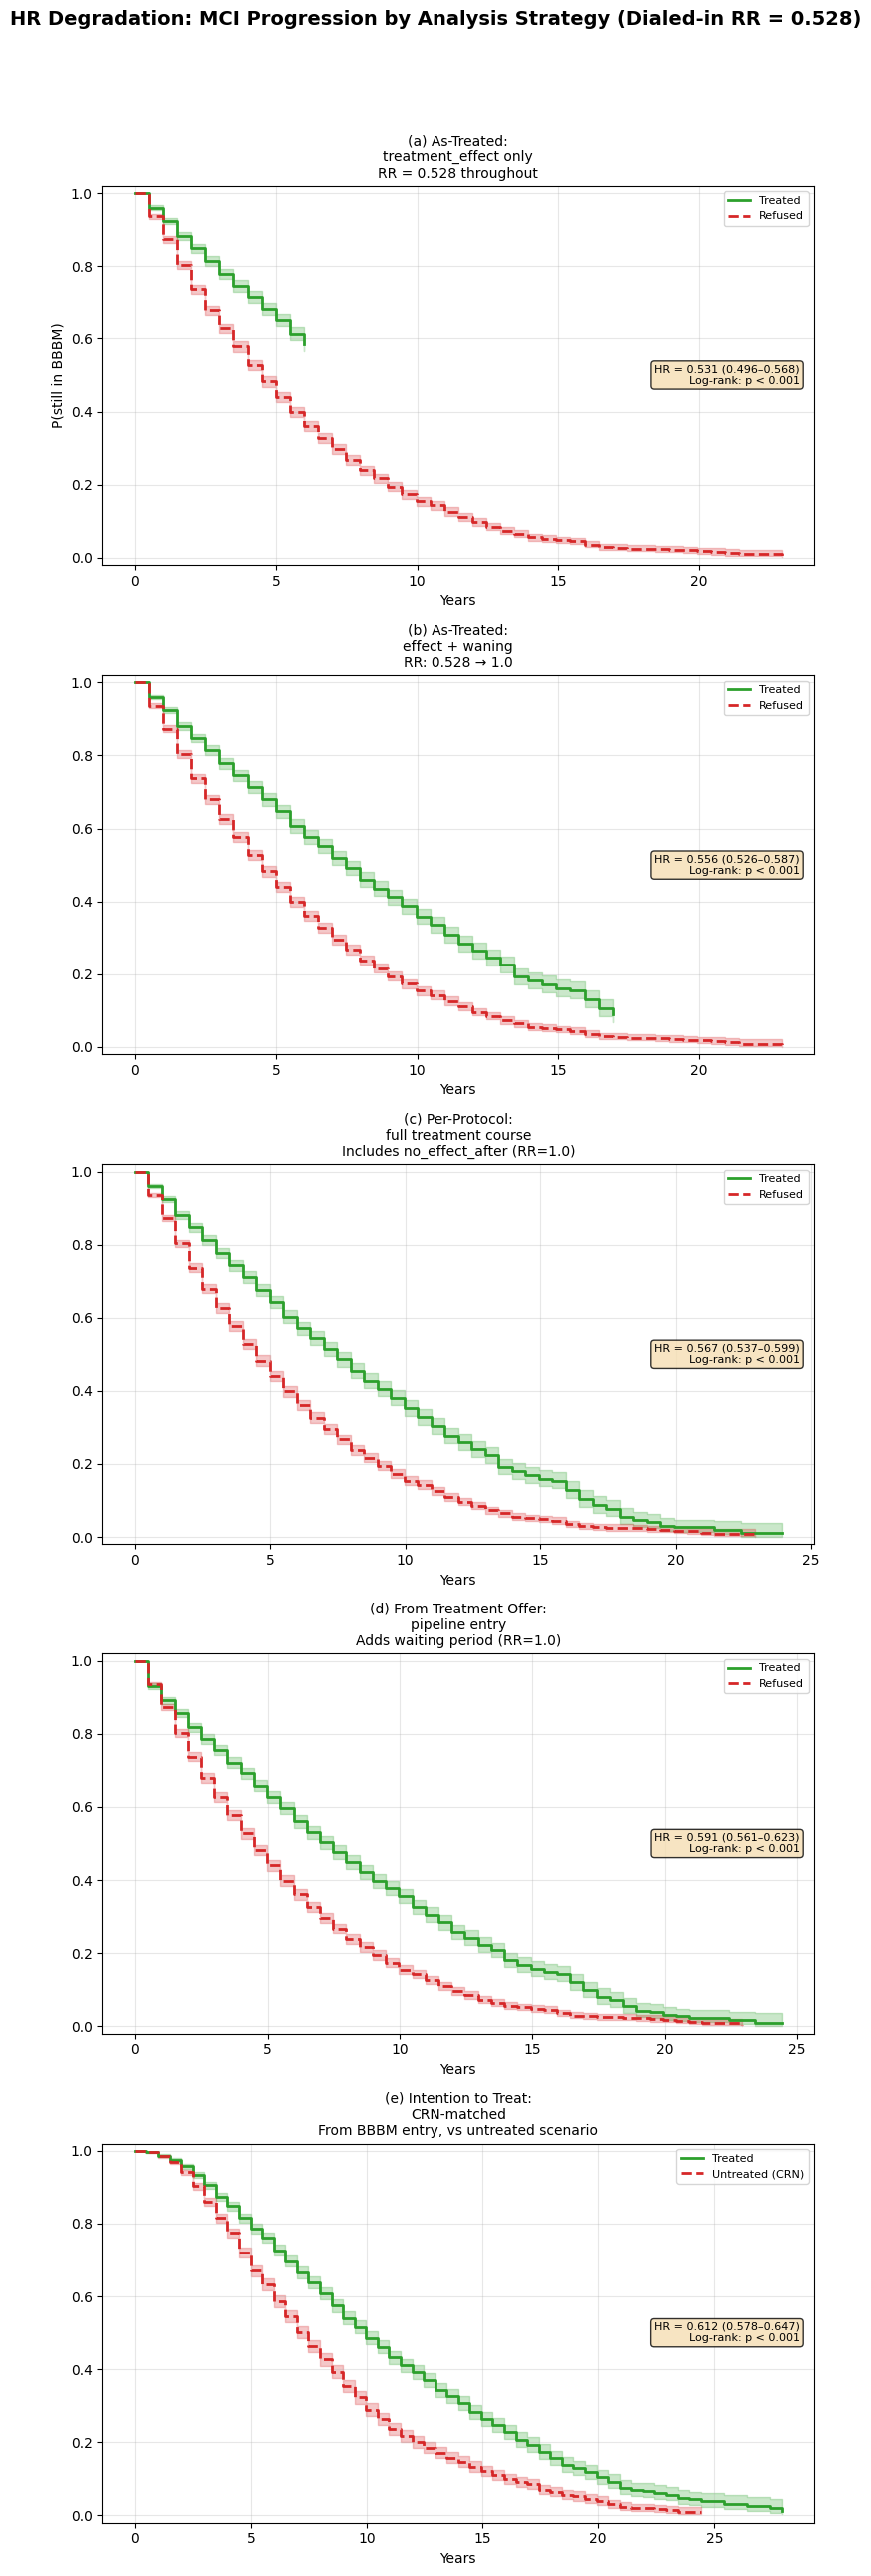

In [10]:
fig, axes = plt.subplots(5, 1, figsize=(8, 25))

hr_results = {}  # store for summary table

for ax, (analysis, title, subtitle) in zip(axes, ANALYSES):
    df = km_datasets[analysis]
    t_mask = df['group'] == 'treated'
    c_mask = ~t_mask

    # Fit and plot KM curves
    kmf_t = KaplanMeierFitter()
    kmf_c = KaplanMeierFitter()

    ctrl_label = 'Untreated (CRN)' if analysis == 'itt' else 'Refused'
    kmf_t.fit(df.loc[t_mask, 'duration'], df.loc[t_mask, 'event'], label='Treated')
    kmf_c.fit(df.loc[c_mask, 'duration'], df.loc[c_mask, 'event'], label=ctrl_label)
    kmf_t.plot_survival_function(ax=ax, color='#2ca02c', linewidth=2)
    kmf_c.plot_survival_function(ax=ax, color='#d62728', linewidth=2, linestyle='--')

    # Compute HR
    hr, hr_lo, hr_hi = compute_hr(
        df.loc[t_mask, 'duration'], df.loc[t_mask, 'event'],
        df.loc[c_mask, 'duration'], df.loc[c_mask, 'event'],
    )

    # Log-rank test
    lr = logrank_test(
        df.loc[t_mask, 'duration'], df.loc[c_mask, 'duration'],
        df.loc[t_mask, 'event'], df.loc[c_mask, 'event'],
    )
    p_str = 'p < 0.001' if lr.p_value < 0.001 else f'p = {lr.p_value:.3f}'

    # Annotate
    ax.text(0.98, 0.5,
            f'HR = {hr:.3f} ({hr_lo:.3f}\u2013{hr_hi:.3f})\n'
            f'Log-rank: {p_str}',
            transform=ax.transAxes, ha='right', va='center', fontsize=8,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    ax.set_title(f'{title}\n{subtitle}', fontsize=10)
    ax.set_xlabel('Years')
    ax.set_ylabel('P(still in BBBM)' if ax == axes[0] else '')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)

    hr_results[analysis] = {
        'hr': hr, 'ci': (hr_lo, hr_hi),
        'chi2': lr.test_statistic, 'p': lr.p_value,
    }

fig.suptitle(
    f'HR Degradation: MCI Progression by Analysis Strategy '
    f'(Dialed-in RR = {TREATMENT_RR})',
    fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

## Step 4: Summary table and interpretation

In [8]:
print(f'Dialed-in treatment RR = {TREATMENT_RR}')
print(f'Population = {POPULATION_SIZE:,}, simulation period = 2022-{TARGET_YEAR}')
print()

# Header
hdr = ['Analysis', 'HR', '95% CI', 'Attenuation', 'chi2', 'p-value']
print(f'{hdr[0]:35s}  {hdr[1]:>6s}  {hdr[2]:>17s}  {hdr[3]:>11s}  {hdr[4]:>8s}  {hdr[5]:>10s}')
print('-' * 95)

labels = {
    'as_treated_effect': 'As-treated: effect only',
    'as_treated_waning': 'As-treated: effect + waning',
    'per_protocol':      'Per-protocol: full course',
    'from_offer':        'From treatment offer',
    'itt':               'Intention to treat (CRN)',
}

for analysis, _, _ in ANALYSES:
    r = hr_results[analysis]
    lo, hi = r['ci']
    atten = r['hr'] - TREATMENT_RR  # how far above the true RR
    p_str = '< 0.001' if r['p'] < 0.001 else f'{r["p"]:.4f}'
    label = labels[analysis]
    print(f'{label:35s}  {r["hr"]:6.3f}  ({lo:.3f}\u2013{hi:.3f})  '
          f'{atten:>+10.3f}  {r["chi2"]:8.1f}  {p_str:>10s}')

Dialed-in treatment RR = 0.528
Population = 10,000, simulation period = 2022-2070

Analysis                                 HR             95% CI  Attenuation      chi2     p-value
-----------------------------------------------------------------------------------------------
As-treated: effect only               0.531  (0.496–0.568)      +0.003     349.9     < 0.001
As-treated: effect + waning           0.556  (0.526–0.587)      +0.028     442.9     < 0.001
Per-protocol: full course             0.567  (0.537–0.599)      +0.039     423.4     < 0.001
From treatment offer                  0.591  (0.561–0.623)      +0.063     398.3     < 0.001
Intention to treat (CRN)              0.612  (0.578–0.647)      +0.084     292.8     < 0.001


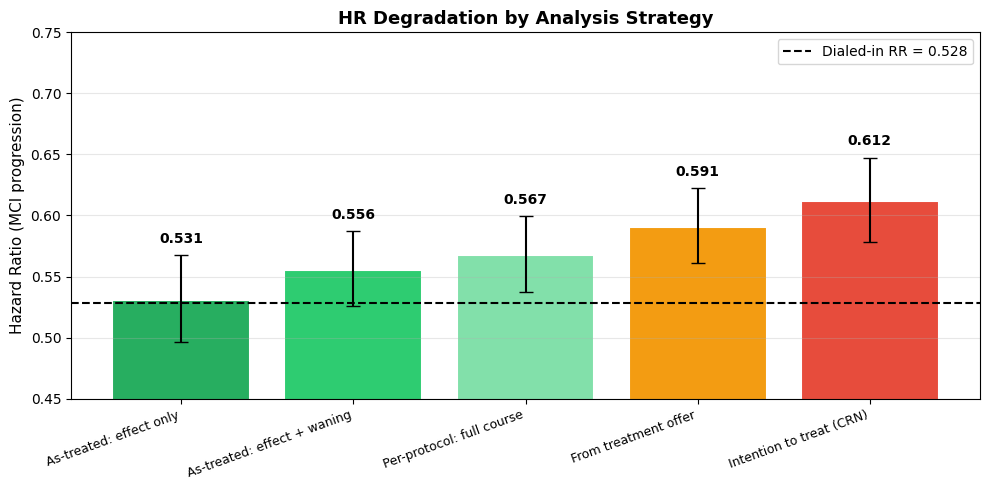

In [9]:
# Visualize the HR degradation as a bar chart
fig, ax = plt.subplots(figsize=(10, 5))

bar_labels = [labels[a] for a, _, _ in ANALYSES]
hrs = [hr_results[a]['hr'] for a, _, _ in ANALYSES]
ci_lo = [hr_results[a]['ci'][0] for a, _, _ in ANALYSES]
ci_hi = [hr_results[a]['ci'][1] for a, _, _ in ANALYSES]
errors = [[h - lo for h, lo in zip(hrs, ci_lo)],
          [hi - h for h, hi in zip(hrs, ci_hi)]]

x = np.arange(len(bar_labels))
colors = ['#27ae60', '#2ecc71', '#82e0aa', '#f39c12', '#e74c3c']
bars = ax.bar(x, hrs, color=colors, edgecolor='white', linewidth=1.5)
ax.errorbar(x, hrs, yerr=errors, fmt='none', color='black', capsize=5, linewidth=1.5)

# Reference line at true RR
ax.axhline(y=TREATMENT_RR, color='black', linestyle='--', linewidth=1.5,
           label=f'Dialed-in RR = {TREATMENT_RR}')
ax.axhline(y=1.0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Labels
for i, (h, lo, hi) in enumerate(zip(hrs, ci_lo, ci_hi)):
    ax.text(i, h + (hi - h) + 0.01, f'{h:.3f}', ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(bar_labels, rotation=20, ha='right', fontsize=9)
ax.set_ylabel('Hazard Ratio (MCI progression)', fontsize=11)
ax.set_title('HR Degradation by Analysis Strategy', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim(0.45, 0.75)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretation

### Why the HR increases (degrades) from left to right

Each step adds person-time during which the treatment is **not** at full effect,
pulling the average HR toward 1.0 (no effect):

1. **As-treated (effect only)**: Isolates the `treatment_effect` window where
   RR = 0.528 is fully applied. The HR matches the dialed-in RR almost exactly.
   This confirms the simulation correctly implements the treatment effect.

2. **As-treated (effect + waning)**: Extends through `waning_effect`, where the
   RR linearly ramps from 0.528 back to 1.0. The average effective RR during
   waning is ~0.764, diluting the overall HR.

3. **Per-protocol (full course)**: Adds `no_effect_after_treatment` time (RR = 1.0).
   Most BBBM exits have already occurred by this point, so the additional
   dilution is modest.

4. **From treatment offer**: Shifts time zero earlier, to `waiting_for_treatment`
   entry (RR = 1.0 for ~1 step). This adds unprotected person-time at the start
   of follow-up.

5. **Intention to treat (CRN)**: The broadest comparison. Uses CRN-matched
   simulants from the testing-only scenario as controls. Time zero = BBBM entry,
   which may be years before treatment starts. All pre-treatment person-time
   (RR = 1.0) is included, maximally diluting the HR.

### Key takeaway

The simulation correctly implements the treatment RR of 0.528. The apparent
attenuation in broader analyses is not a bug -- it reflects the real-world
challenge that treatment is not instantaneous, not permanent, and not universal.
The progression from as-treated to ITT mirrors what clinical trialists observe
when moving between analysis strategies.